<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/boosting/Credit_Scorecards_with_XGBoost_and_W&B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{xgboost-credit-scorecard} -->

<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{xgboost-credit-scorecard, v=examples} -->

<img src="http://wandb.me/mini-diagram" width="600" alt="Weights & Biases" />

# Interpretable Credit Scorecards with XGBoost

Handcrafted credit scorecards are still common across many areas of Finance, partially due to their interpretability vs more complex credit score modelling methods. However there are ways to leverage more complex modelling techniques such as XGBoost in credit assessment that can increase the performance of the assessment, whilst retaining interpretability for internal Risk Management functions as well as external regulators 

At Nvidia GTC21 Paul Edwards at ScotiaBank [presented](https://www.nvidia.com/en-us/on-demand/session/gtcspring21-s31327/) how XGBoost can be used to construct more performant credit scorecards that remain interpretable. They also kindly [shared sample code](https://github.com/rapidsai-community/showcase/tree/main/event_notebooks/GTC_2021/credit_scorecard) which we will use throughout this notebook, credit to [Stephen Denton](stephen.denton@scotiabank.com) from Scotiabank for sharing this code publicly.

### [Click here](https://wandb.ai/morgan/credit_scorecard) to view and interact with a live W&B Dashboard built with this notebook

# In this notebook

In this colab we'll cover how Weights and Biases enables regulated entities to 
- **Track and version** their data ETL pipelines (locally or in cloud services such as S3 and GCS)
- **Track experiment results** and store trained models 
- **Visually inspect** metrics and candidate credit scorecards
- **Optimize performance** with hyperparameter sweeps

**Track Experiments and Results**

In this notebook we'll train a XGBoost model to classify whether submitted loan applications will default or not. We will track all of the training hyperparameters and output metrics in order to generate an Experiments Dashboard like the one below:

Screenshot 2021-05-24 at 17.55.17.png

**Generate Credit Scorecard for Loan Defaults**

We'll then use the decision trees in this trained model to generate a credit scorecard. We'll use `XGBoost`'s `interaction_constraints` to prevent interactions of the same feature type within an individual decision tree as well as its `monotonic_constraints` to encode known business logic of how some features have a monotonic relationship to the `loan_default` target

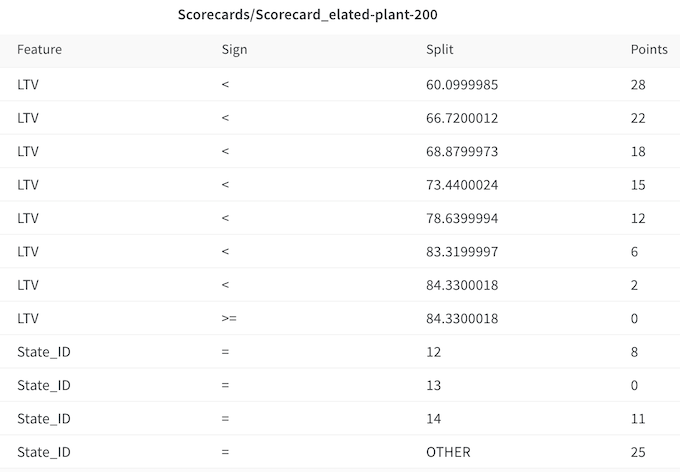

**Run a Hyperparameter Sweep to Find the Best HyperParameters**

Weights and Biases also enables you to do hyperparameter sweeps, either with our own [Sweeps functionality](https://docs.wandb.ai/guides/sweeps) or with our [Ray Tune integration](https://docs.wandb.ai/guides/sweeps/advanced-sweeps/ray-tune). See our docs for a full guide of how to use more advanced hyperparameter sweeps options.

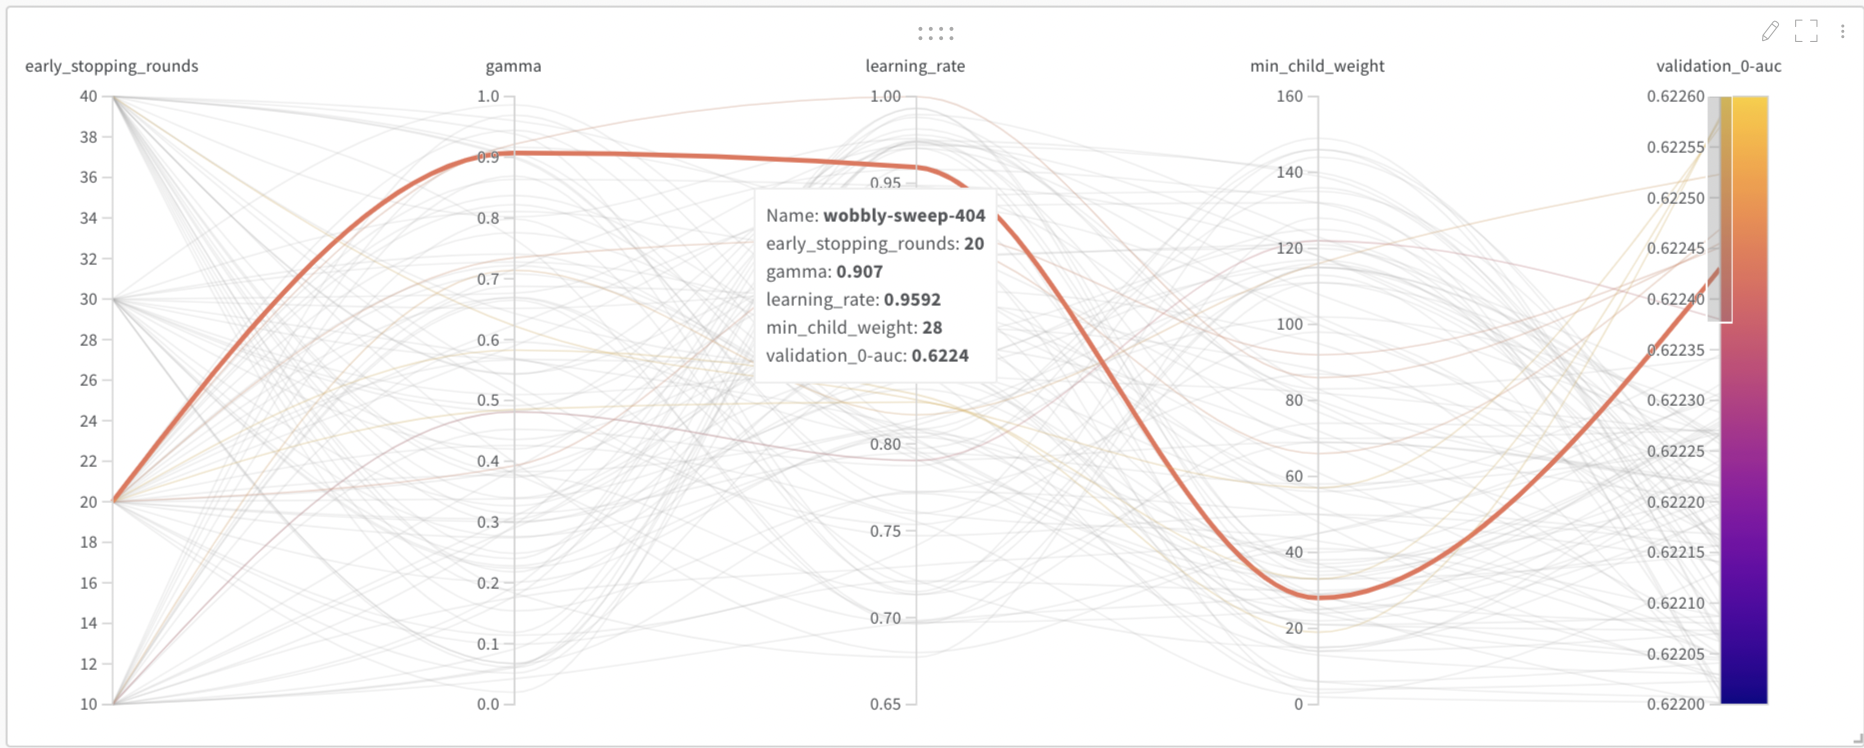

# Setup

Package versions used: 
- numpy version: 1.19.2
- pandas version: 1.2.3
- scipy version: 1.6.2
- matplotlib version: 3.4.1
- scikit-learn version: 0.24.1
- XGBoost version: 1.3.3

In [ ]:
!pip install -qq wandb
!pip install -qq xgboost==1.3.3
!pip install -Uqq scikit-learn==0.24.1

In [ ]:
import ast
import sys
import json
from pathlib import Path
from dill.source import getsource
from dill import detect

import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp
from sklearn import metrics
from sklearn import model_selection
import xgboost as xgb

pd.set_option('display.max_columns', None)

# Data

## AWS S3, Google Cloud Storage and W&B Artifacts

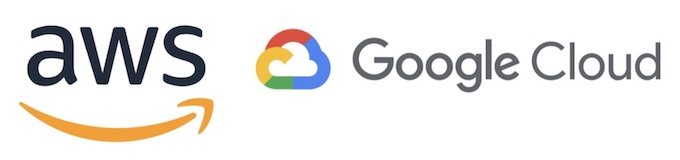

Weights and Biases **Artifacts** enable you to log end-to-end training pipelines to ensure your experiments are always reproducible.

Data privacy is critical to Weights & Biases and so we support the creation of Artifacts from reference locations such as your own private cloud such as AWS S3 or Google Cloud Storage. Local, on-premises of W&B are also available upon request. 

By default, W&B stores artifact files in a private Google Cloud Storage bucket located in the United States. All files are encrypted at rest and in transit. For sensitive files, we recommend a private W&B installation or the use of reference artifacts.

## Artifacts Reference Example
**Create an artifact with the S3/GCS metadata**

The artifact only consists of metadata about the S3/GCS object such as its ETag, size, and version ID (if object versioning is enabled on the bucket).

```
run = wandb.init()
artifact = wandb.Artifact('mnist', type='dataset')
artifact.add_reference('s3://my-bucket/datasets/mnist')
run.log_artifact(artifact)   
```

**Download the artifact locally when needed**

W&B will use the metadata recorded when the artifact was logged to retrieve the files from the underlying bucket.

```
artifact = run.use_artifact('mnist:latest', type='dataset')
artifact_dir = artifact.download()
```

See [Artifact References](https://docs.wandb.ai/guides/artifacts/references) for more on how to use Artifacts by reference, credentials setup etc.

## Login to W&B
Login to Weights and Biases and then add your W&B username as the entity that will be used when creating all your runs 

In [ ]:
import wandb
wandb.login()

ENTITY = None # ENTER Your team name here if you have one.

## Vehicle Loan Dataset

We will be using a simplified version of the [Vehicle Loan Default Prediction dataset](https://www.kaggle.com/sneharshinde/ltfs-av-data) from L&T which has been stored in W&B Artifacts. 

In [ ]:
# specify a folder to save the data, a new folder will be created if it doesn't exist
data_dir = Path('.')
model_dir = Path('models')
model_dir.mkdir(exist_ok=True)

id_vars = ['UniqueID']
targ_var = 'loan_default'

Create function to pickle functions

In [ ]:
def function_to_string(fn):
    return getsource(detect.code(fn)) 

#### Download Data from W&B Artifacts

We will download our dataset from W&B Artifacts. First we need to create a W&B run object, which we will use to download the data. Once the data is downloaded it will be one-hot encoded. This processed data will then be logged to the same W&B as a new Artifact. By logging to the W&B that downloaded the data, we tie this new Artifact to the raw dataset Artifact

In [ ]:
run = wandb.init(entity=ENTITY, project='credit_scorecard', job_type='preprocess-data', config={'wandb_nb':'wandb_credit_soc'})  # config is optional here

Download the subset of the vehicle loan default data from W&B, this contains `train.csv` and `val.csv` files. This will also download `data_utils.py` and `scorecard.py` which contain helper functions to process the data and create our scorecard

In [ ]:
dataset_art = run.use_artifact('morgan/credit_scorecard/vehicle_loan_defaults:latest', type='dataset')
dataset_dir = dataset_art.download(data_dir)

In [ ]:
from data_utils import (
    describe_data_g_targ,
    one_hot_encode_data,
    create_feature_interaction_constraints,
    get_monotonic_constraints,
    load_training_data,
    calculate_credit_scores
)

from scorecard import generate_scorecard

#### One-Hot Encode the Data

In [ ]:
# Load data into Dataframe
dataset = pd.read_csv(data_dir/'vehicle_loans_subset.csv')

# One Hot Encode Data
dataset, p_vars = one_hot_encode_data(dataset, id_vars, targ_var)

# Save Preprocessed data
processed_data_path = data_dir/'proc_ds.csv'
dataset.to_csv(processed_data_path, index=False)

#### Log Processed Data to W&B Artifacts

In [ ]:
# Create a new artifact for the processed data, including the function that created it, to Artifacts
processed_ds_art = wandb.Artifact(name='vehicle_defaults_processed', 
                                    type='processed_dataset',
                                    description='One-hot encoded dataset',
                                    metadata={'preprocessing_fn': function_to_string(one_hot_encode_data)}
                                 )

# Attach our processed data to the Artifact 
processed_ds_art.add_file(processed_data_path)

# Log this Artifact to the current wandb run
run.log_artifact(processed_ds_art);

run.finish()

## Get Train/Validation Split

Here we show an alternative pattern for how to create a wandb run object. In the cell below, the code to split the dataset is wrapped with a call to `wandb.init() as run`. 

Here we will:

- Start a wandb run
- Download our one-hot-encoded dataset from Artifacts
- Do the Train/Val split and log the params used in the split 
- Log the new `trndat` and `valdat` datasets to Artifacts
- Finish the wandb run automatically

In [ ]:
with wandb.init(entity=ENTITY, project='credit_scorecard', job_type='train-val-split', config={'wandb_nb':'wandb_credit_soc'}) as run:     # config is optional here
    
    # Download the subset of the vehicle loan default data from W&B
    dataset_art = run.use_artifact('vehicle_defaults_processed:latest', type='processed_dataset')
    dataset_dir = dataset_art.download(data_dir)
    dataset = pd.read_csv(processed_data_path)
    
    # Set Split Params
    test_size = 0.25
    random_state = 42
    
    # Log the splilt params
    run.config.update({'test_size':test_size, 'random_state': random_state})
    
    # Do the Train/Val Split
    trndat, valdat = model_selection.train_test_split(dataset, test_size=test_size, 
                                                      random_state=random_state, stratify=dataset[[targ_var]])

    print(f'Train dataset size: {trndat[targ_var].value_counts()} \n')
    print(f'Validation dataset sizeL {valdat[targ_var].value_counts()}')
    
    # Save split datasets
    train_path = data_dir/'train.csv'
    val_path = data_dir/'val.csv'
    trndat.to_csv(train_path, index=False)
    valdat.to_csv(val_path, index=False)
    
    # Create a new artifact for the processed data, including the function that created it, to Artifacts
    split_ds_art = wandb.Artifact(name='vehicle_defaults_split', 
                                        type='train-val-dataset',
                                        description='Processed dataset split into train and valiation',
                                        metadata={'test_size': test_size, 'random_state': random_state}
                                     )
    
    # Attach our processed data to the Artifact 
    split_ds_art.add_file(train_path)
    split_ds_art.add_file(val_path)
    
    # Log the Artifact
    run.log_artifact(split_ds_art)

#### Inspect Training Dataset
Get an overview of the training dataset

In [ ]:
trndict = describe_data_g_targ(trndat, targ_var)
trndat.head()

### Log Dataset with W&B Tables

With W&B Tables you can log, query, and analyze tabular data that contains rich media such as images, video, audio and more. With it you can understand your datasets, visualize model predictions, and share insights, for more see more in our [W&B Tables Guide](https://docs.wandb.ai/guides/data-vis)

In [ ]:
# Create a wandb run, with an optional "log-dataset" job type to keep things tidy
run = wandb.init(entity=ENTITY, project='credit_scorecard', job_type='log-dataset', config={'wandb_nb':'wandb_credit_soc'})  # config is optional here

# Create a W&B Table and log 1000 random rows of the dataset to explore
table = wandb.Table(dataframe=trndat.sample(1000))

# Log the Table to your W&B workspace
wandb.log({'processed_dataset': table})

# Close the wandb run
wandb.finish()

# Modelling

## Modelling Constraints

We need to set Feature Interaction Constraints in order to be able to use XGBoost to create a scorecard and we also set some Monotonic Constraints that encode some business logic into the model. We will log these constraints to the wandb run when we are training our XGBoost model so that our model training is reproducible

#### Feature Interaction Constraints

Set feature interaction constraints such that no between-variable interactions are allowed. This is necessary to be able to use XGBoost to develop a scorecard. For more on Feature Interaction Constraints see this [XGBoost tutorial](https://xgboost.readthedocs.io/en/latest/tutorials/feature_interaction_constraint.html)

In [ ]:
x_consts, interaction_consts, consts_path = create_feature_interaction_constraints(p_vars, data_dir)

#### Monotonic Constraints
Manually Define which variables will have a Monotonic Relationship to our target, `loan_default`. For more on Monotonic Constraints see this [XGBoost tutorial](https://xgboost.readthedocs.io/en/latest/tutorials/monotonic.html)

In [ ]:
monotonic_vars = ['PERFORM_CNS_SCORE', 'AgeInMonths', 'LTV']

monotonic_constraints_str = get_monotonic_constraints(monotonic_vars, p_vars, data_dir)

## Fit the XGBoost Model

We will now fit an XGBoost model to classify whether a vehicle loan application will result in a default or not

### Training on GPU
If you'd like to train your XGBoost model on your GPU, simply change set the following in the parameters you pass to XGBoost:

```
'tree_method': 'gpu_hist'
```

#### 1) Initialise a W&B Run

In [ ]:
run = wandb.init(entity=ENTITY, project='credit_scorecard', job_type='train-model', config={'wandb_nb':'wandb_credit_soc'})  # config is optional here

#### 2) Setup and Log the Model Parameters

- Using monotonic constraints means that `tree_method` mush be `exact, hist or gpu_hist`
- `n_estimators` will define the number of trees used in the final scorecard

In [ ]:
base_rate = round(trndict['base_rate'], 6) 
early_stopping_rounds = 40

In [ ]:
bst_params = {
        'objective': 'binary:logistic'
        , 'base_score': base_rate
        , 'gamma': 1               ## def: 0
        , 'learning_rate': 0.1     ## def: 0.1
        , 'max_depth': 3
        , 'min_child_weight': 100  ## def: 1
        , 'n_estimators': 25
        , 'nthread': 24 
        , 'random_state': 42
        , 'reg_alpha': 0
        , 'reg_lambda': 0          ## def: 1
        , 'eval_metric': ['auc', 'logloss']
        , 'tree_method': 'hist'  # use `gpu_hist` to train on GPU
        , 'interaction_constraints' : interaction_consts
        , 'monotone_constraints' : monotonic_constraints_str
    }

Log the xgboost training parameters to the W&B run config 

In [ ]:
run.config.update(dict(bst_params))
run.config.update({'early_stopping_rounds':early_stopping_rounds})

#### 3) Load the Training Data from W&B Artifacts

In [ ]:
# Load our training data from Artifacts
trndat, valdat = load_training_data(run=run, data_dir=data_dir, 
                                    artifact_name='vehicle_defaults_split:latest')

## Extract target column as a series
y_trn = trndat.loc[:,targ_var].astype(int)
y_val = valdat.loc[:,targ_var].astype(int)

#### 4) Fit the model

To log all our xgboost model parameters we used the `wandb_callback`. This will . See the W&B [boosting models docs](https://docs.wandb.ai/guides/integrations/boosting), including documentation for other libraries that have integrated W&B including LightGBM and more.

In [ ]:
from wandb.xgboost import wandb_callback

# Initialize the XGBoostClassifier
xgbmodel = xgb.XGBClassifier(**bst_params, use_label_encoder=False)

# Train the model, using the wandb_callback for logging
xgbmodel.fit(trndat[p_vars], y_trn, eval_set=[(valdat[p_vars], y_val)], 
             early_stopping_rounds=run.config['early_stopping_rounds'],
             callbacks=[wandb_callback()])

bstr = xgbmodel.get_booster()

#### 5) Save the Trained Model to W&B Artifacts

In [ ]:
# Save the booster to disk
model_name = f'{run.name}_model.json'
model_path = model_dir/model_name
bstr.save_model(str(model_path))

# Get the booster's config
config = json.loads(bstr.save_config())

# Log the trained model to W&B Artifacts, including the booster's config
model_art = wandb.Artifact(name=model_name, type='model', metadata=dict(config))
model_art.add_file(model_path)
run.log_artifact(model_art);

#### 6) Log the Booster Config to W&B

In [ ]:
# Add the additional data from the booster's config to the run config
run.config.update(dict(config))

# Log booster metrics
run.summary["best_score"] = bstr.best_score
run.summary["best_iteration"] = bstr.best_iteration
run.summary["best_ntree_limit"] = bstr.best_ntree_limit

#### 7) Log Additional Train and Evaluation Metrics to W&B

In [ ]:
# Get train and validation predictions
trnYpreds = xgbmodel.predict_proba(trndat[p_vars])[:,1]
valYpreds = xgbmodel.predict_proba(valdat[p_vars])[:,1] 

# Log additional Train metrics
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_trn, trnYpreds) 
run.summary['train_ks_stat'] = max(true_positive_rate - false_positive_rate)
run.summary['train_auc'] = metrics.auc(false_positive_rate, true_positive_rate)
run.summary['train_log_loss'] = -(y_trn * np.log(trnYpreds) + (1-y_trn) * np.log(1-trnYpreds)).sum() / len(y_trn)

# Log additional Validation metrics
ks_stat, ks_pval = ks_2samp(valYpreds[y_val==1], valYpreds[y_val==0])
run.summary["val_ks_2samp"] = ks_stat
run.summary["val_ks_pval"] = ks_pval
run.summary["val_auc"] = metrics.roc_auc_score(y_val, valYpreds)
run.summary["val_acc_0.5"] = metrics.accuracy_score(y_val, np.where(valYpreds >= 0.5, 1, 0))
run.summary["val_log_loss"] = -(y_val * np.log(valYpreds) 
                                     + (1-y_val) * np.log(1-valYpreds)).sum() / len(y_val)

#### 8) Log the ROC Curve and Feature Importance Charts To W&B

In [ ]:
# Log the ROC curve to W&B
valYpreds_2d = np.array([1-valYpreds, valYpreds])  # W&B expects a 2d array
y_val_arr = y_val.values
d = 0
while len(valYpreds_2d.T) > 10000:
    d +=1
    valYpreds_2d = valYpreds_2d[::1, ::d]
    y_val_arr = y_val_arr[::d]
run.log({"ROC_Curve" : wandb.plot.roc_curve(y_val_arr, valYpreds_2d.T,
                                           labels=['no_default','loan_default'],
                                           classes_to_plot=[1])})

# Log Feature Importance
fi = bstr.get_fscore()
fi_data = [[k, fi[k]] for k in fi]
table = wandb.Table(data=fi_data, columns = ["Feature", "Importance"])
run.log({"Feature Importance" : wandb.plot.bar(table, "Feature",
                               "Importance", title="Feature Importance")})

# Create Scorecard

Using the decision trees created from the XGBoost model we can now create a scorecard based upon the splits in the decision trees. We then award a certain number of points to a loan application after each row of the scorecard is evaluated

In [ ]:
pointscard = generate_scorecard(bstr, base_rate=base_rate)

#### Inspect Scorecard

The scorecard is made up of individual decision trees. Looking at the first tree, we can see we split by LTV (Loan to Value) and award points depending on the LTV

In [ ]:
tree_i=0
display(pointscard.loc[[tree_i]])

#### Log the Scorecard to W&B

In [ ]:
cols_to_log = ['Tree', 'Feature', 'Sign', 'Split', 'Points']
pc = pointscard.copy()
pc['Tree'] = pointscard.index
pc = pc[cols_to_log].copy()

wandb.log({f"Scorecards/Scorecard_{run.name}": wandb.Table(dataframe=pc, 
                                   columns=cols_to_log, allow_mixed_types=True)})

## Calculate Credit Scores

We can now calculate the actual credit score of loan applications for the first `n_samples` rows in our validation dataset

In [ ]:
n_samples = 5000
val_scores = calculate_credit_scores(n_samples=n_samples, p_vars=p_vars,
                                     pointscard=pointscard, 
                                     valdat=valdat)

#### Log Credit Scores vs Model Probability to W&B

In [ ]:
data = [[x, y] for (x, y) in zip(valYpreds[:n_samples], val_scores)]
wandb.Table.MAX_ROWS = n_samples
table = wandb.Table(data=data, columns = ["Model Prob", "Credit Score"])
wandb.log({f"Validation_Scores/Validation_Scores_{run.name}": table})

#### Finish the W&B Run

In [ ]:
run.finish()

# HyperParameter Sweep

Weights and Biases also enables you to do hyperparameter sweeps, either with our own [Sweeps functionality](https://docs.wandb.ai/guides/sweeps/python-api) or with our [Ray Tune integration](https://docs.wandb.ai/guides/sweeps/advanced-sweeps/ray-tune). See [our docs](https://docs.wandb.ai/guides/sweeps/python-api) for a full guide of how to use more advanced hyperparameter sweeps options.

**[Click Here](https://wandb.ai/morgan/credit_score_sweeps/sweeps/iuppbs45)** to check out the results of a 1000 run sweep generated using this notebook

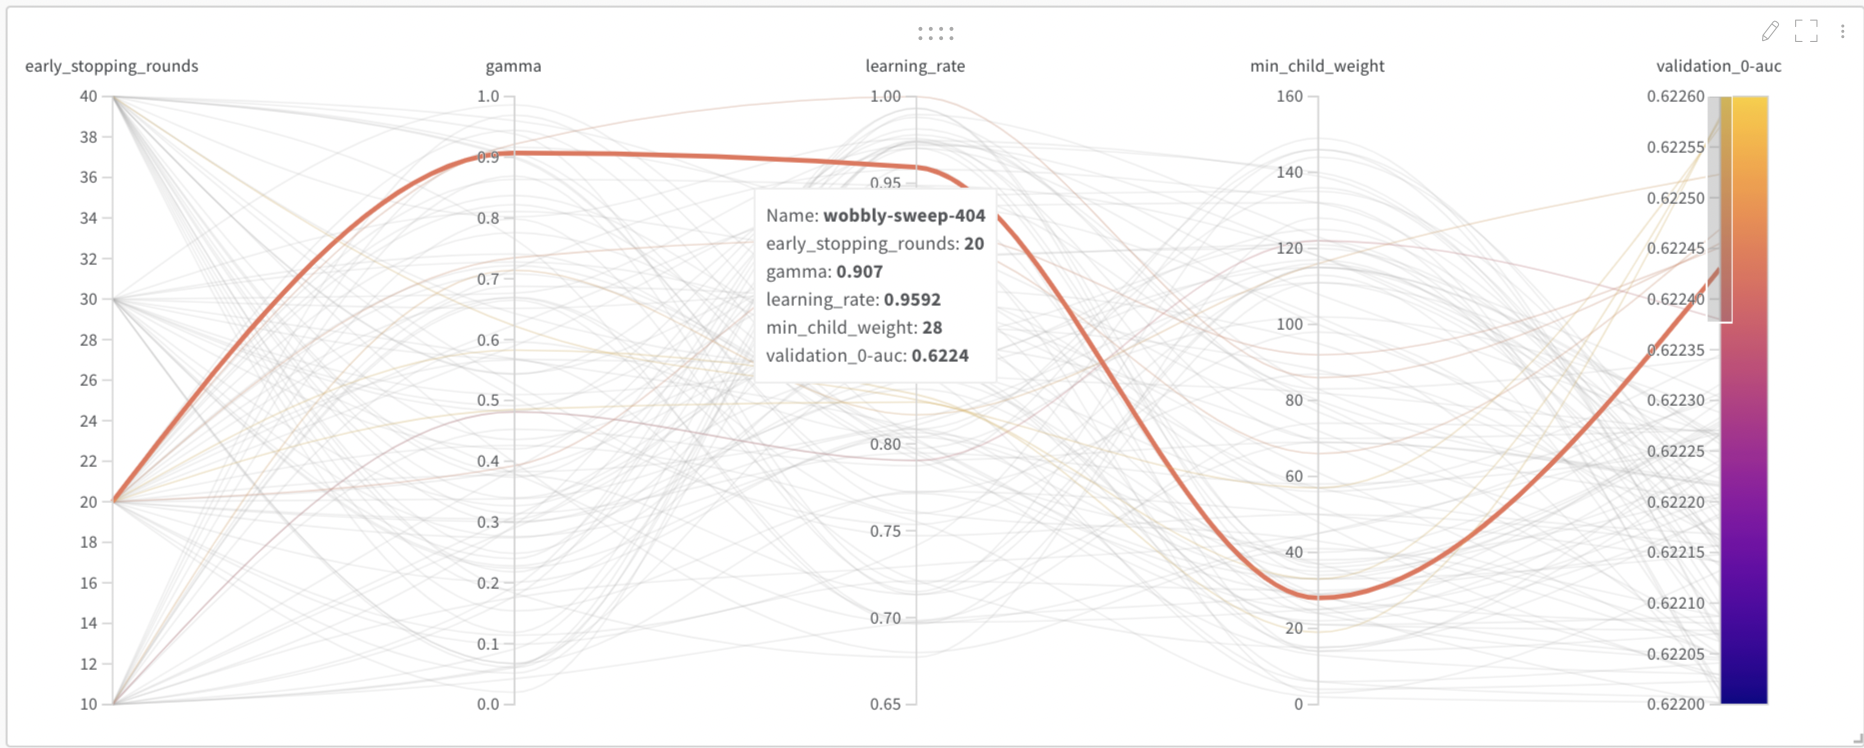

#### Define the Sweep Config
First we define the hyperparameters to sweep over as well as the type of sweep to use:

In [ ]:
sweep_config = {
  "method" : "random",
  "parameters" : {
    "learning_rate" :{
      "min": 0.001,
      "max": 1.0
    },
    "gamma" :{
      "min": 0.001,
      "max": 1.0
    },
    "min_child_weight" :{
      "min": 1,
      "max": 150
    },
    "early_stopping_rounds" :{
      "values" : [10, 20, 30, 40]
    },
  }
}

sweep_id = wandb.sweep(sweep_config, project="credit_scorecard_sweep")

#### Define the Training Function

Then we define the function that will train our model using these hyperparameters. Note that `job_type='sweep'` when initialising the run, so that we can easily filter out these runs from our main workspace if we need to

In [ ]:
def train():     
    with wandb.init() as run:
    
        bst_params = {
            'objective': 'binary:logistic'
            , 'base_score': base_rate
            , 'gamma': run.config['gamma']
            , 'learning_rate': run.config['learning_rate']
            , 'max_depth': 3
            , 'min_child_weight': run.config['min_child_weight']
            , 'n_estimators': 25
            , 'nthread': 24 
            , 'random_state': 42
            , 'reg_alpha': 0
            , 'reg_lambda': 0          ## def: 1
            , 'eval_metric': ['auc', 'logloss']
            , 'tree_method': 'hist' 
            , 'interaction_constraints' : interaction_consts
            , 'monotone_constraints' : monotonic_constraints_str
        }

        # Initialize the XGBoostClassifier
        xgbmodel = xgb.XGBClassifier(**bst_params, use_label_encoder=False)

        # Train the model, using the wandb_callback for logging
        xgbmodel.fit(trndat[p_vars], y_trn, eval_set=[(valdat[p_vars], y_val)], 
                     early_stopping_rounds=run.config['early_stopping_rounds'],
                     callbacks=[wandb_callback()])

        bstr = xgbmodel.get_booster()
        
        # Add the additional data from the booster's config to the run config
        run.config.update(dict(config))
        run.config.update({'wandb_nb':'wandb_credit_soc'})

        # Log booster metrics
        run.summary["best_score"] = bstr.best_score
        run.summary["best_iteration"] = bstr.best_iteration
        run.summary["best_ntree_limit"] = bstr.best_ntree_limit
        
        # Get train and validation predictions
        trnYpreds = xgbmodel.predict_proba(trndat[p_vars])[:,1]
        valYpreds = xgbmodel.predict_proba(valdat[p_vars])[:,1] 

        # Log additional Train metrics
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_trn, trnYpreds) 
        run.summary['train_ks_stat'] = max(true_positive_rate - false_positive_rate)
        run.summary['train_auc'] = metrics.auc(false_positive_rate, true_positive_rate)
        run.summary['train_log_loss'] = -(y_trn * np.log(trnYpreds) + (1-y_trn) * np.log(1-trnYpreds)).sum() / len(y_trn)

        # Log additional Validation metrics
        ks_stat, ks_pval = ks_2samp(valYpreds[y_val==1], valYpreds[y_val==0])
        run.summary["val_ks_2samp"] = ks_stat
        run.summary["val_ks_pval"] = ks_pval
        run.summary["val_auc"] = metrics.roc_auc_score(y_val, valYpreds)
        run.summary["val_acc_0.5"] = metrics.accuracy_score(y_val, np.where(valYpreds >= 0.5, 1, 0))
        run.summary["val_log_loss"] = -(y_val * np.log(valYpreds) 
                                             + (1-y_val) * np.log(1-valYpreds)).sum() / len(y_val)

#### Run the Sweeps Agent

In [ ]:
count = 10 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

## W&B already in your favorite ML library

Weights and Biases has integrations in all of your favourite ML and Deep Learning libraries such as:

- Pytorch Lightning
- Keras
- Hugging Face
- JAX
- Fastai
- XGBoost
- Sci-Kit Learn
- LightGBM 

**See [W&B integrations for details](https://docs.wandb.ai/guides/integrations)** 